# Anomaly Detection in time series

## Data preprocessing

We are dealing with the so-called 'n-gram' data.

In [95]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.figsize'] = [14.0, 5.5]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 17

In [2]:
import os
import glob

df_lst = []
for file in glob.glob("../data/DataFrames/ee*.json.df"):
    with open(file, 'rb') as handle:
        ldf = pickle.load(handle)
        df_lst.append(ldf)

df = pd.concat(df_lst)

In [ ]:
pd.set_option('max_colwidth', 700)
df.head(4)

We drop the `thread_id` column because it has only one value:

In [ ]:
df.thread_id.value_counts()

In [3]:
df = df.drop(columns=['thread_id'])
df['node_id'] = df['node_id'].astype(int)
df = df.sort_values('time_by_lasttime')

In [4]:
sf = df.kl.value_counts()
freq = pd.DataFrame({'n_gram':sf.index, 'number_of_calls':sf.values})

# Define max and min threshold
min = 10000
max = float("inf")

subset = freq[(freq['number_of_calls'] > min) & (freq['number_of_calls'] < max)]
subset = subset.sample(frac=0.55)
subset = subset.sort_values('number_of_calls', ascending=False)

### Granularity: Aggregate or Node mode?

We use aggregation mode, i.e., data from all nodes will aggregate for anomaly detection. In this case, we are dealing with multivariate time series.

We select some portions of the data for the testing different algorithms (without changing the original data distribution).

In [5]:
def sample_portion(df, n_gram, frac = 0.03, seed=1):
    df_ = df[df['kl'] == n_gram]
    # total length of the sample
    length = int(len(df_) * frac)
    # select where to start taking the data
    np.random.seed(seed)
    start_position = np.random.randint(0, (len(df_) - length))
    df_sample = df_.iloc[start_position:start_position + length]
    
    # drop unused columns
    df_sample = df_sample.drop(columns=['kl', 'node_id'])
    df_sample = df_sample.sort_values('time_by_lasttime').reset_index(drop=True)
    df_sample = df_sample.rename(columns={'time_by_lasttime': 'timestamp', 'time_diff' : 'run_time'})
    df_sample.name = n_gram
    
    return df_sample   

In [63]:
# check all possible parameters
plt.rcParams.keys();

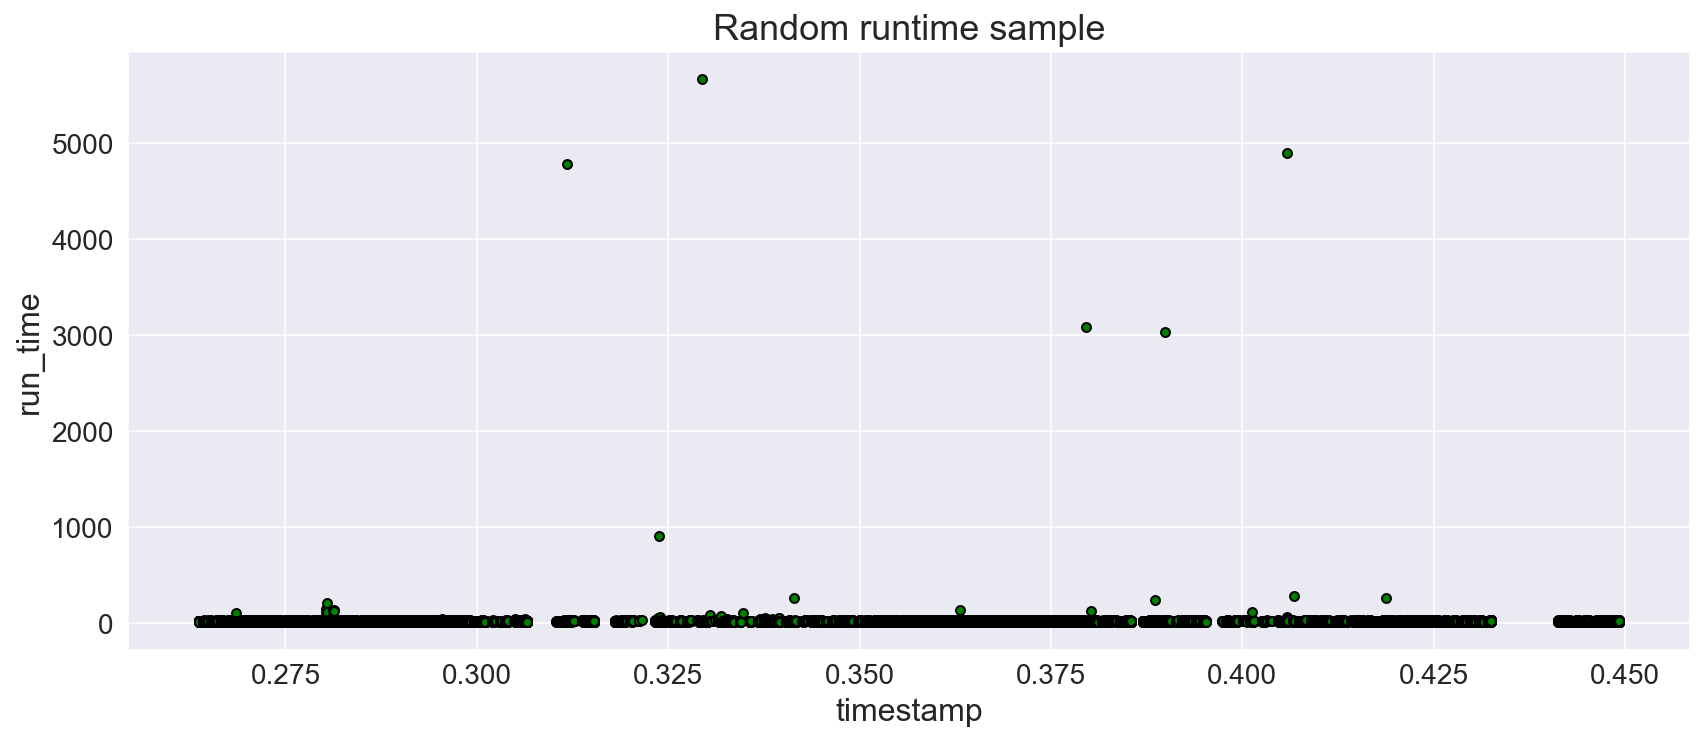

In [98]:
func = 'voidLAMMPS_NS::Run::command(int,char**):voidLAMMPS_NS::Verlet::run(int):MPI_Send()'
df_sample = sample_portion(df, func, frac=0.2, seed=21)
df_sample.plot.scatter('timestamp', 'run_time', c='green', s=20, edgecolor='k')
plt.title('Random runtime sample')
plt.show()

## Current implementation using `mean` and `std`

In [93]:
def moving_gaussian(df, window_frac = 0.2, c = 6):
    window = int(window_frac * len(df))
    mean = df.run_time.rolling(window = window).mean()
    mean.iloc[:(window-1)] = mean.iloc[window]
    std = df.run_time.rolling(window = window).std()
    std.iloc[:(window-1)] = std.iloc[window]

    upper = mean + c * std
    lower = mean - c * std

    a1 = df.run_time > upper
    a2 = df.run_time < lower
    
    anomalies = np.logical_or(a1, a2)
    normal = np.logical_not(anomalies)
    outlier = df[anomalies]
    normal = df[normal]
    
    ratio = len(outlier)/len(df)  
    plt.figure()
    if ratio >= 0.01:
        plt.title("Gaussian, outlier_ratio={:.2f}, c={}, window={}".format(ratio, c, window))
    else:
        plt.title("Gaussian, {} outliers in {} points, c={}, window={}".format(len(outlier), len(df), 
                                                                               c, window))
        
    g = plt.scatter(normal['timestamp'],  normal['run_time'], c='green', s=15, edgecolor='k')
    h = plt.scatter(outlier['timestamp'], outlier['run_time'], c='red', s=55, edgecolor='k')
    plt.xlabel('timestamp')
    plt.ylabel('run_time')
    plt.axis('tight')
    plt.legend([g, h],["Normal","Outlier"])
    plt.show()
    
    return outlier, normal

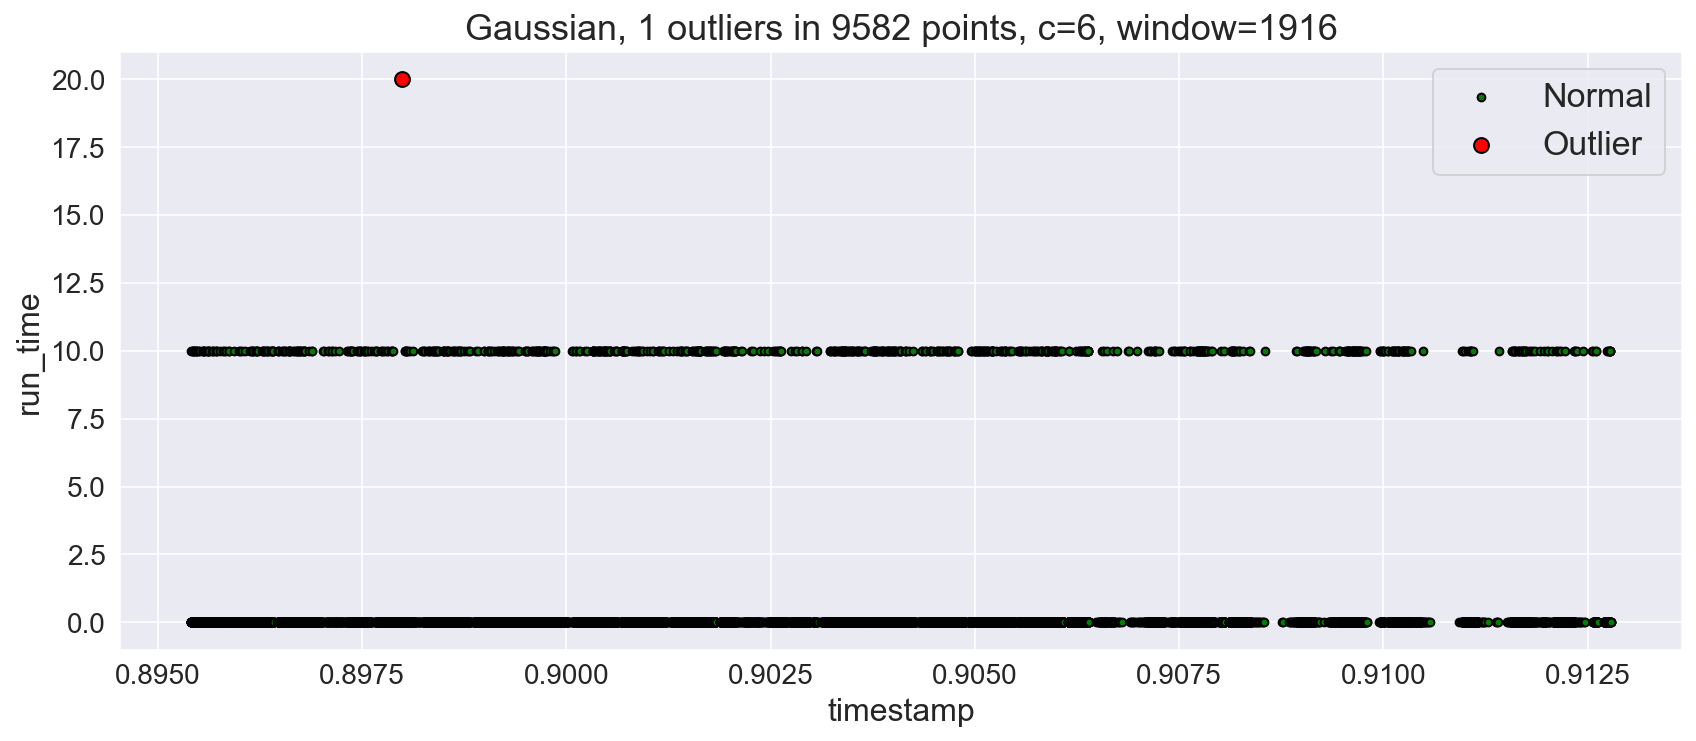

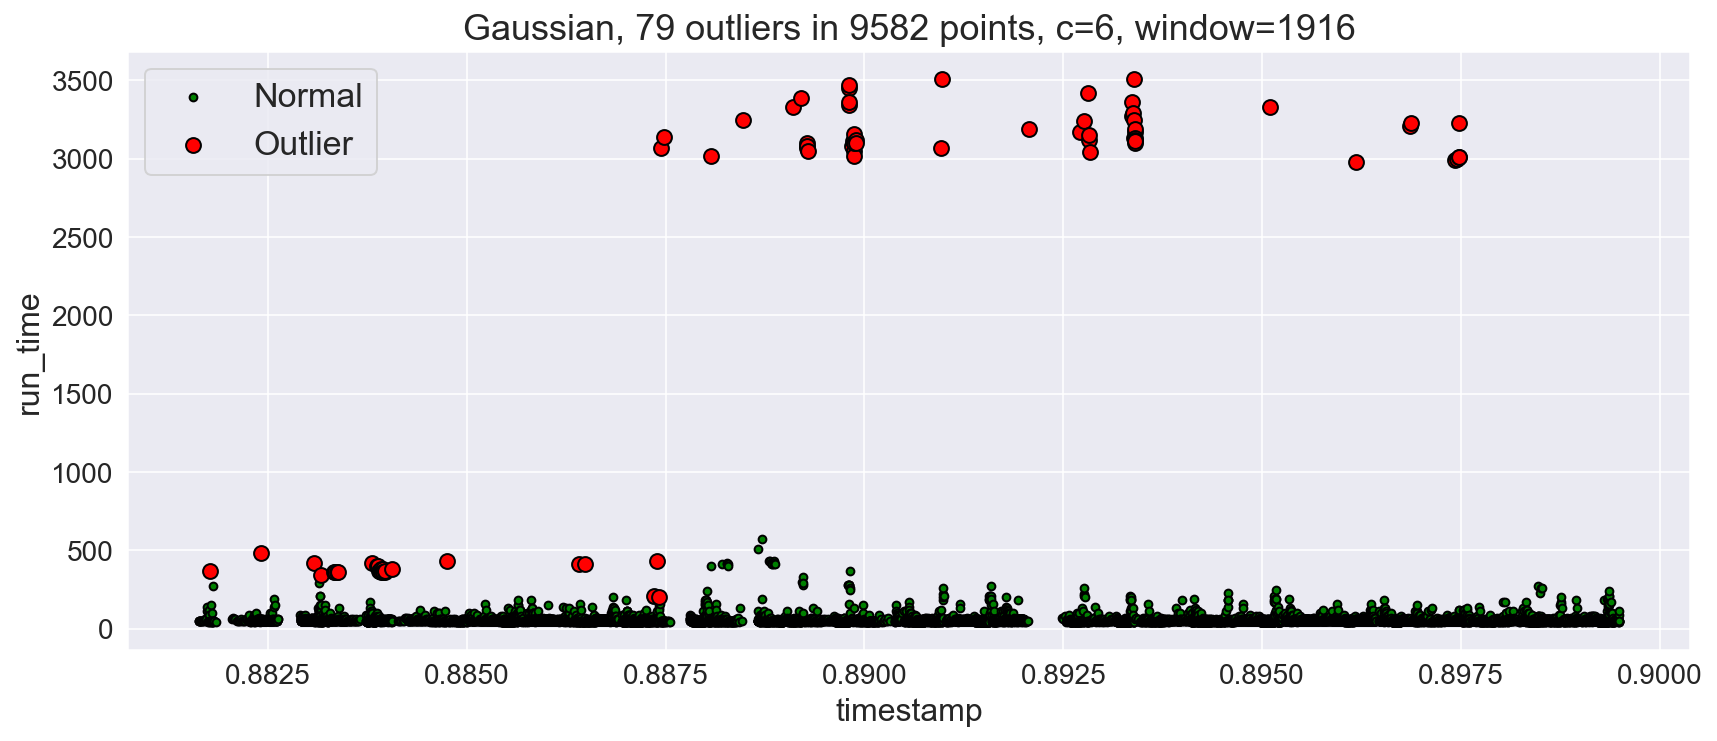

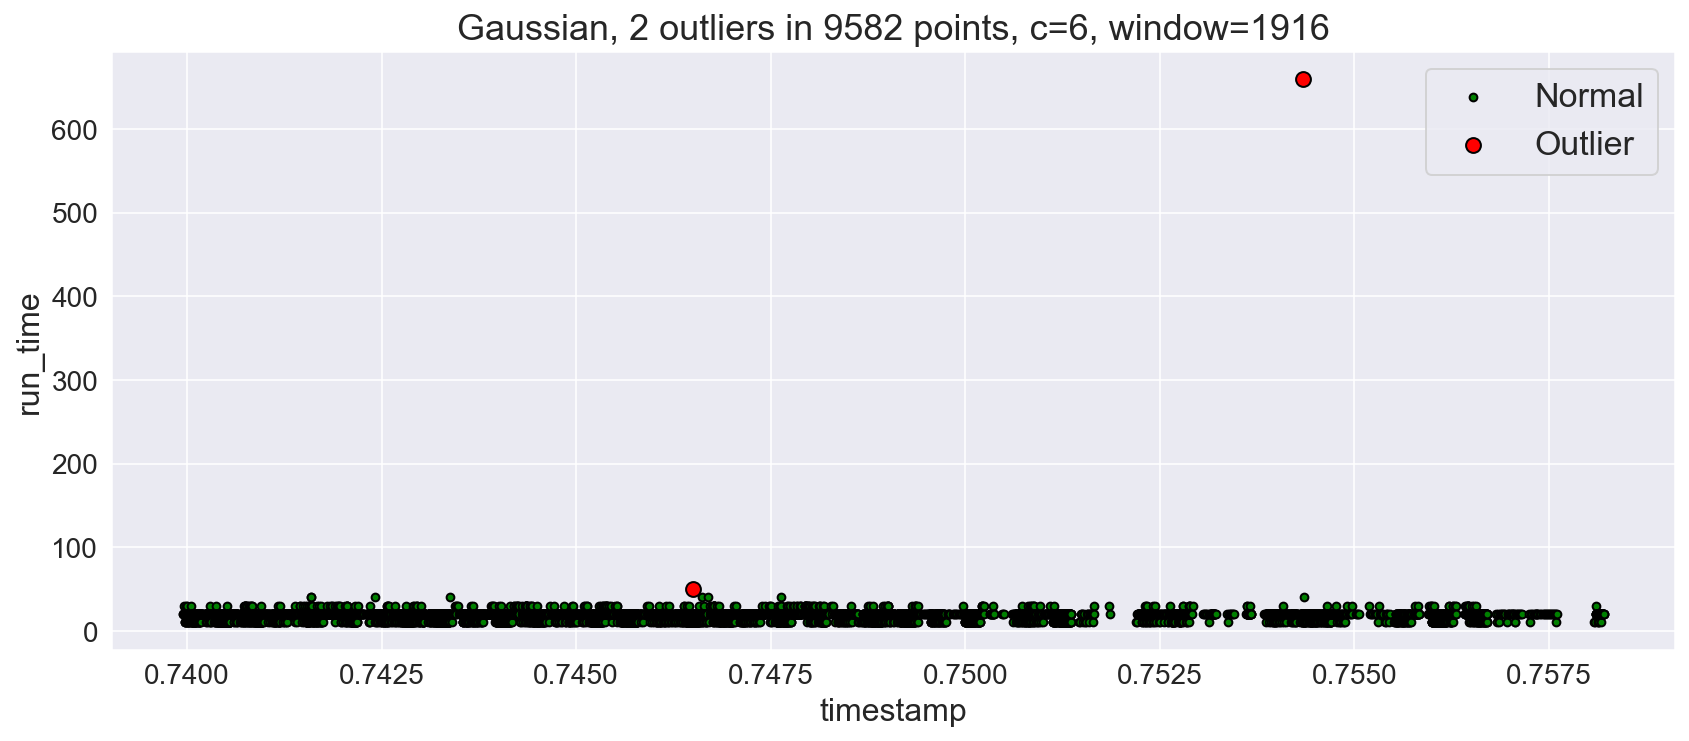

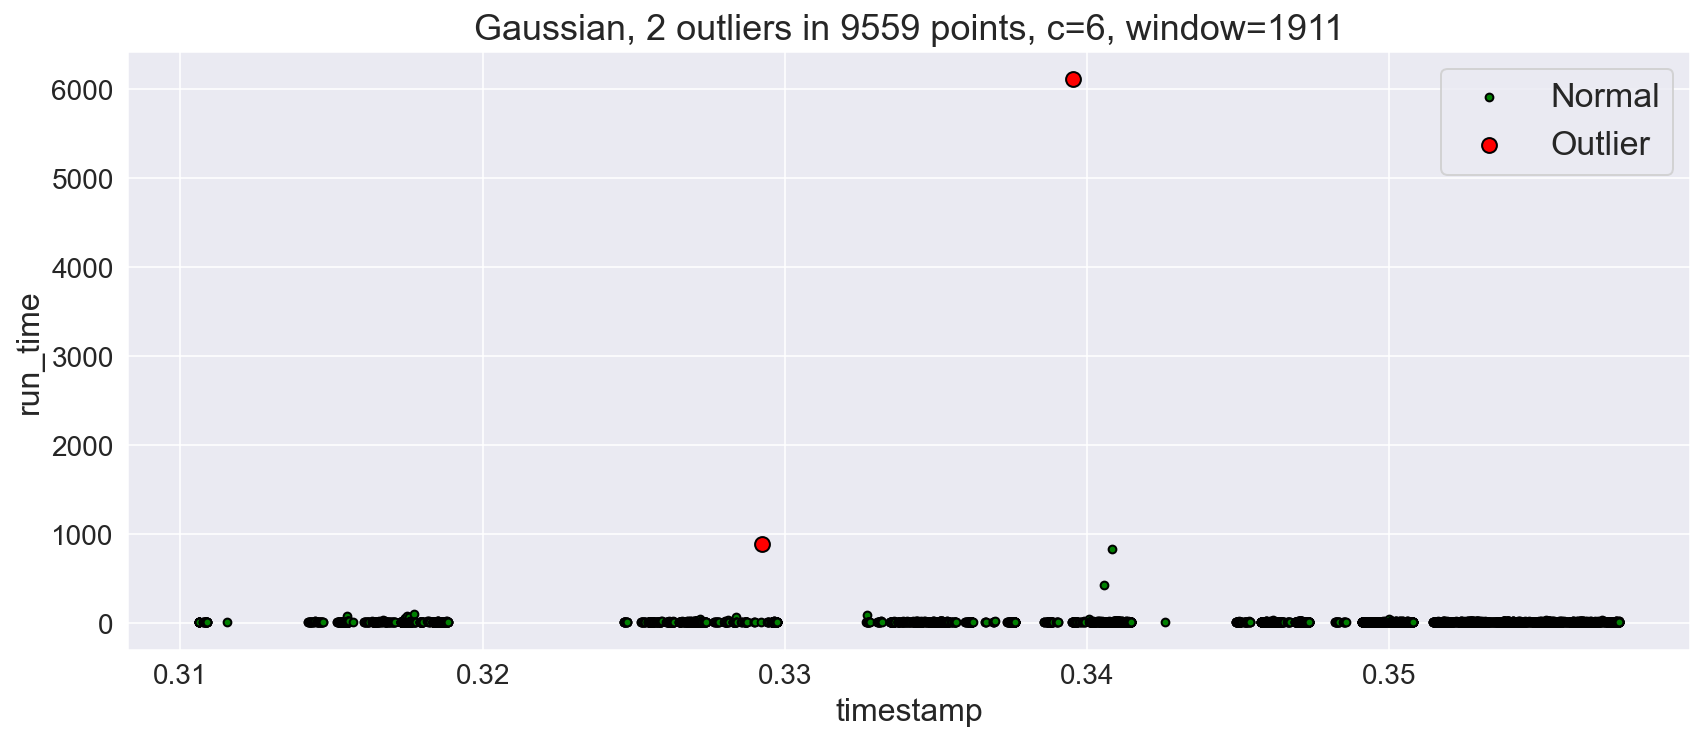

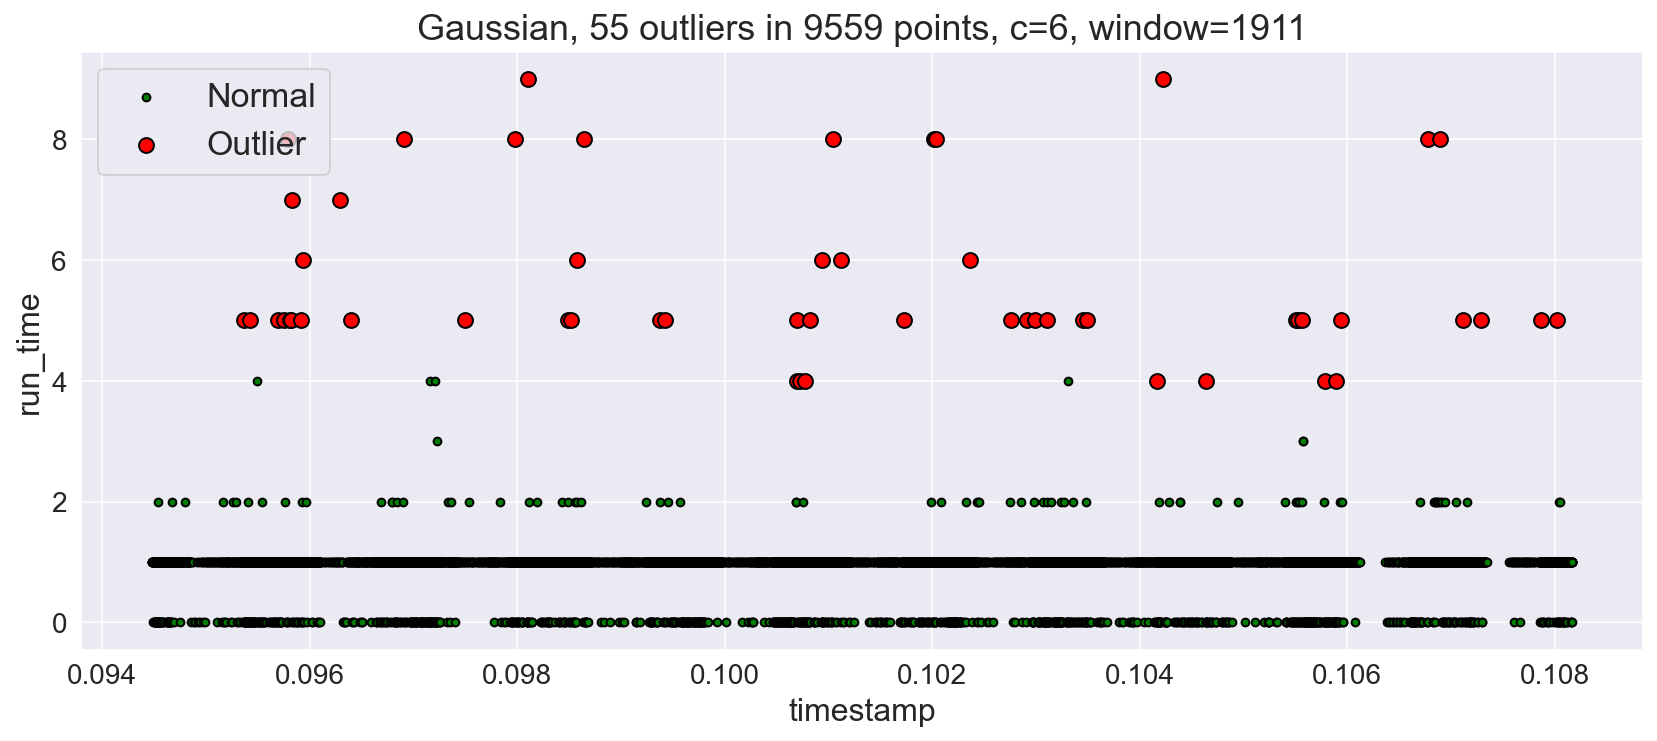

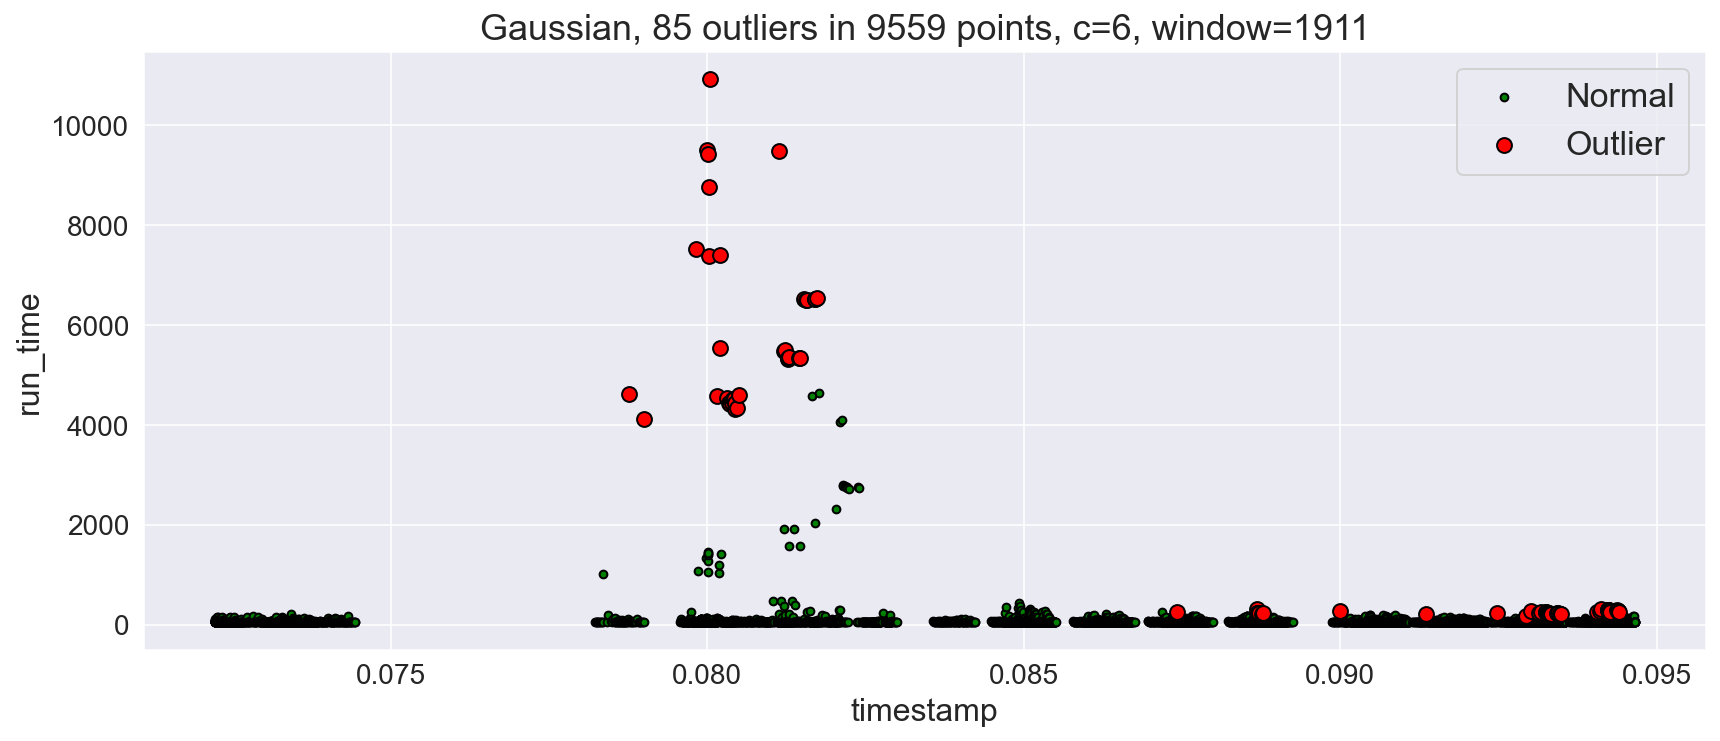

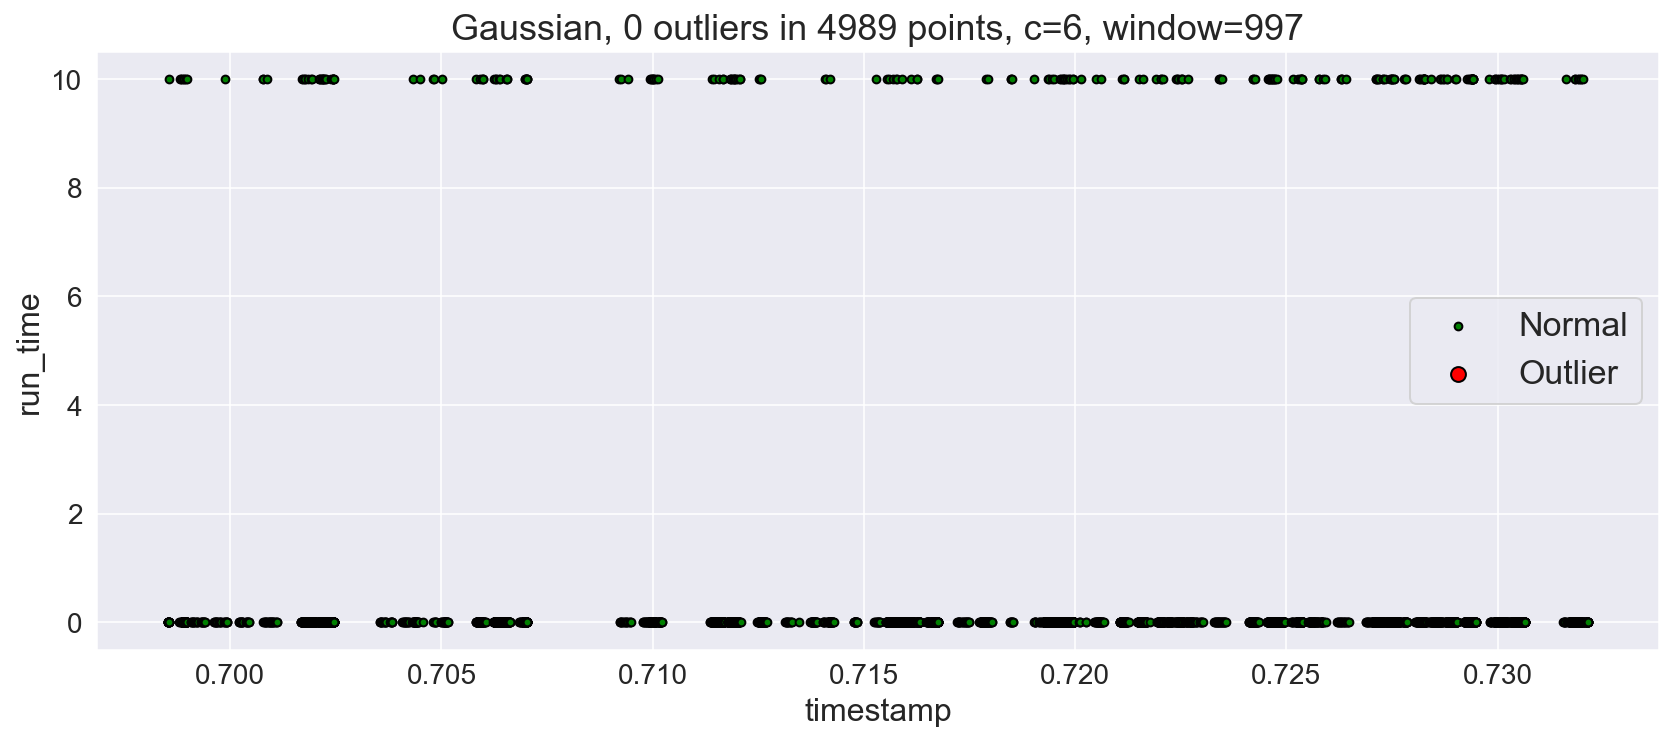

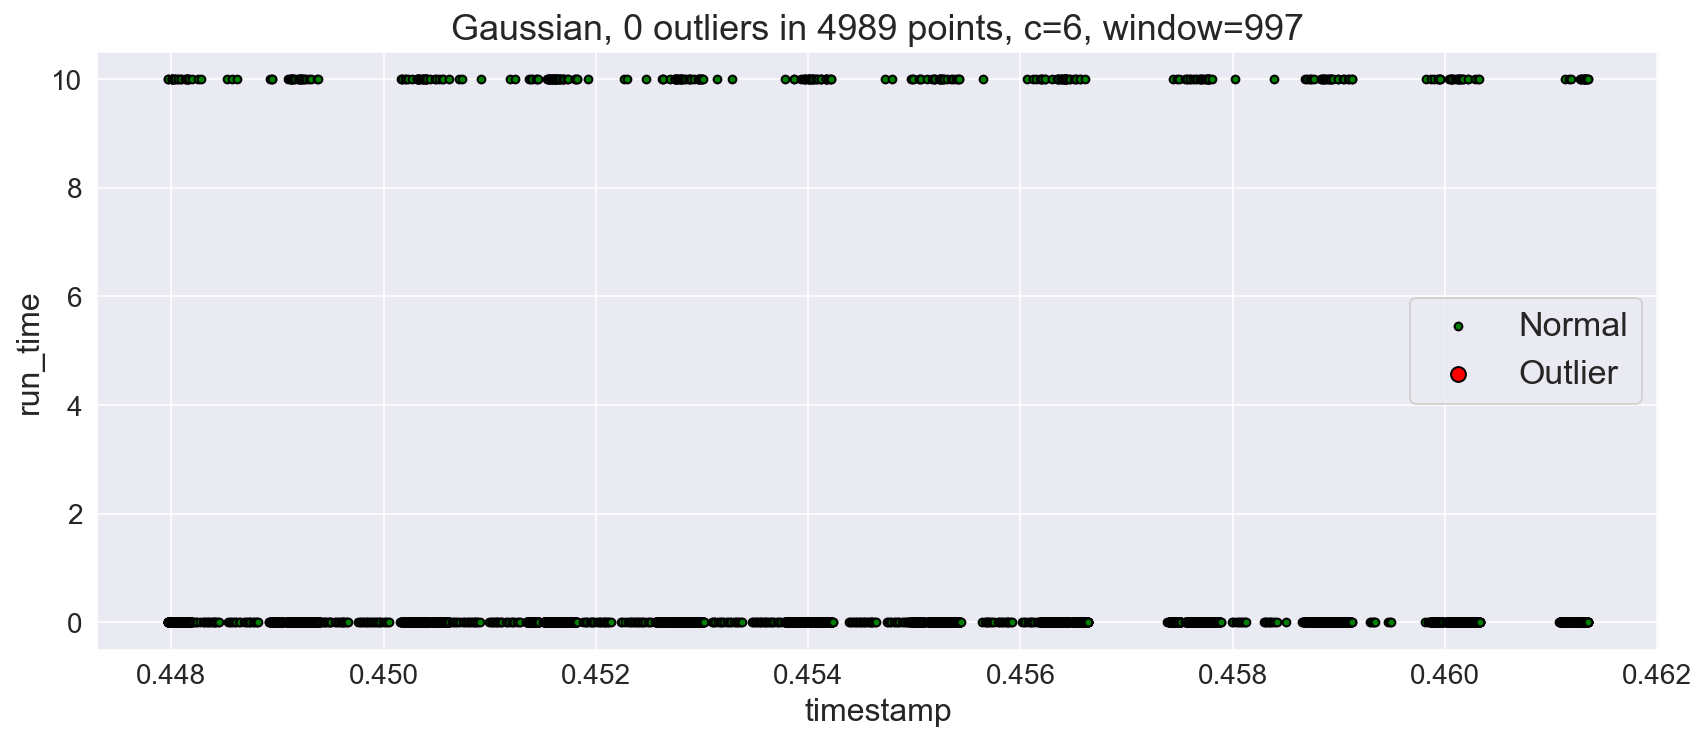

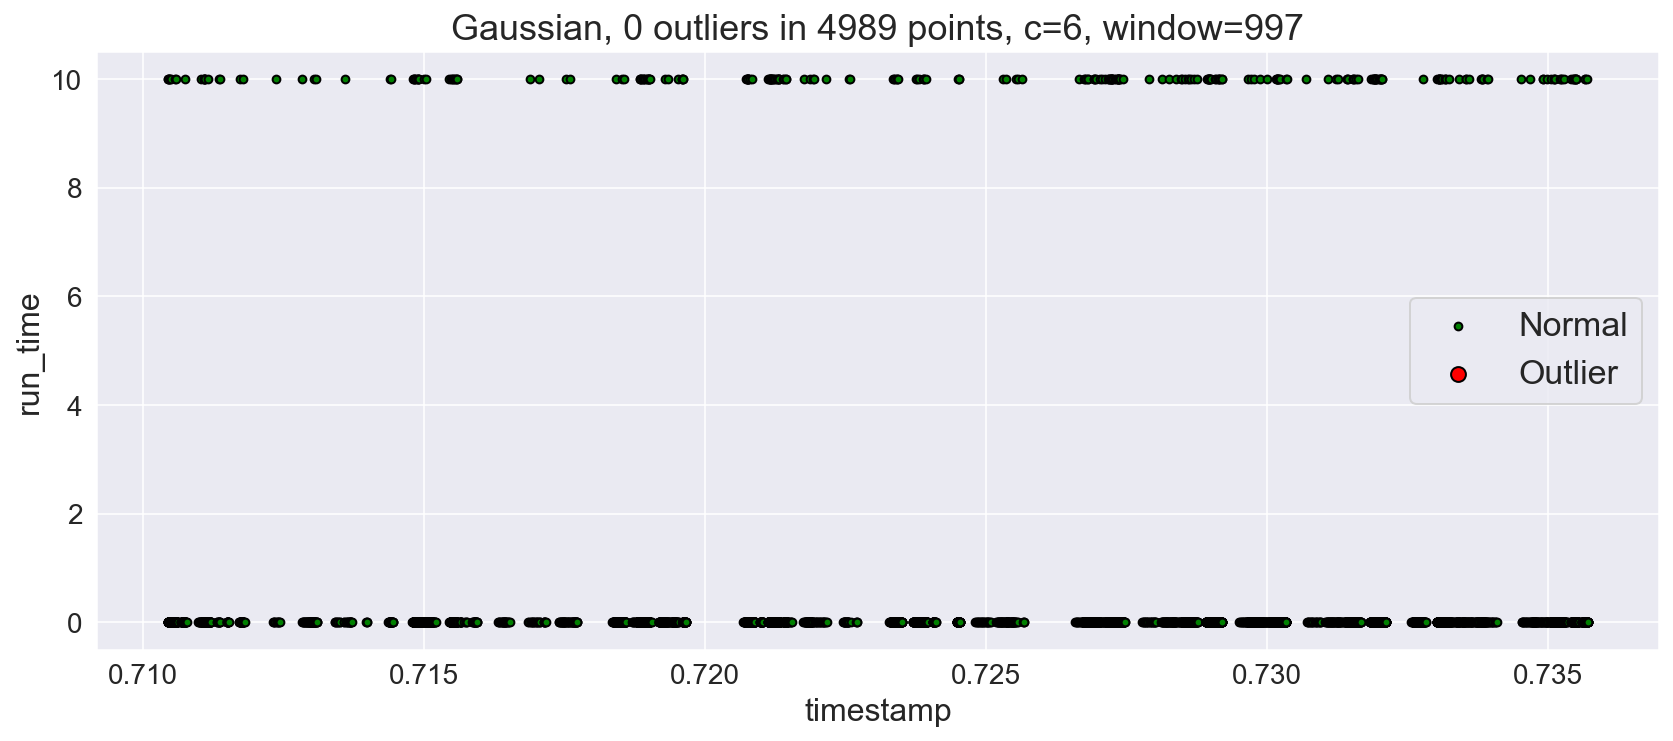

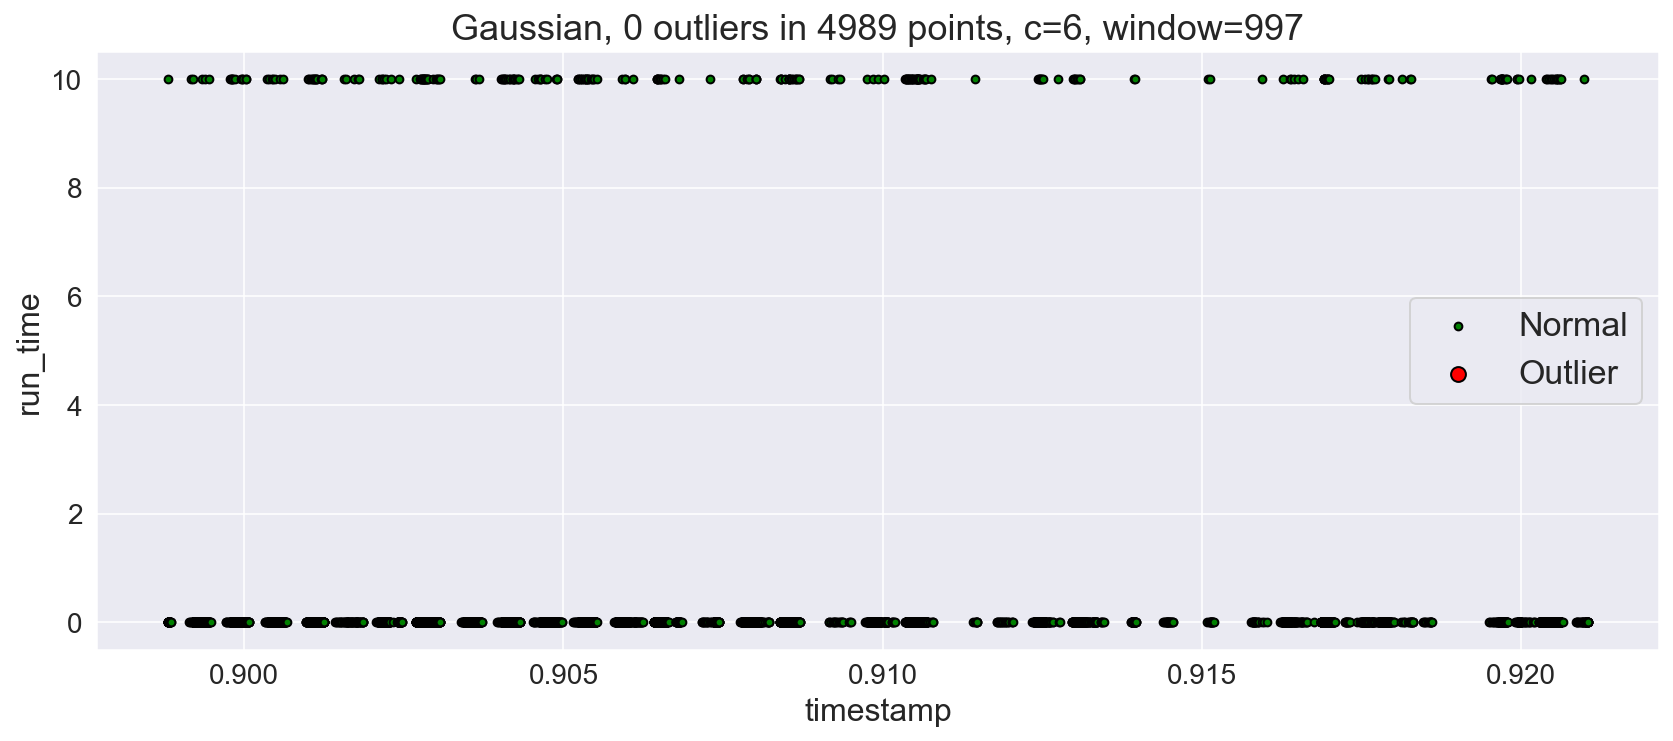

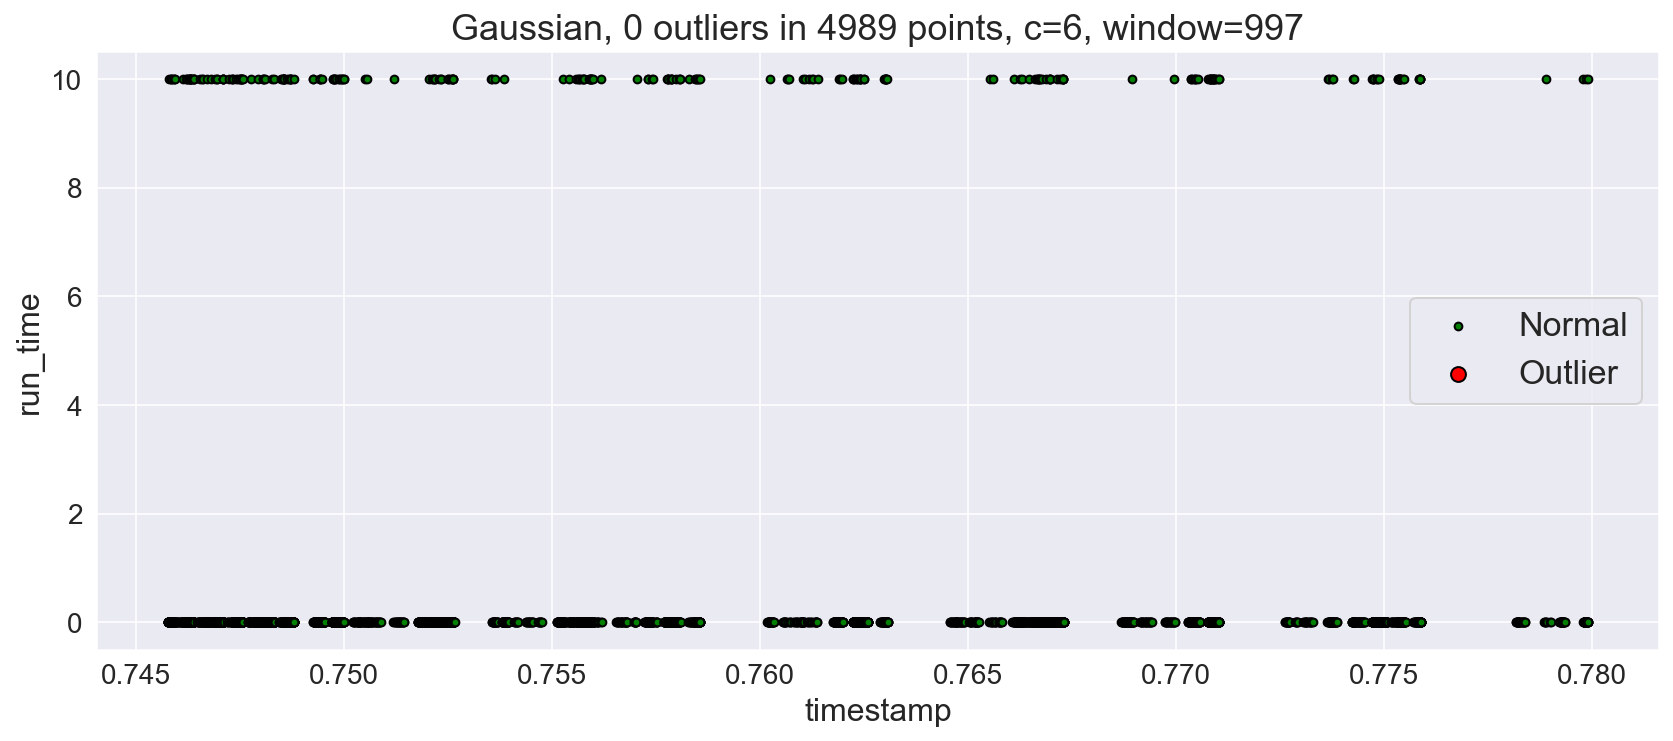

In [99]:
for i in range(len(subset)):
    func = freq.iloc[i]['n_gram']
    sample = sample_portion(df, func, seed = 11*i)
    moving_gaussian(sample);

## Online or Batch Mode?

Is our approach strictly online?

## Local Outlier Factor

The `LocalOutlierFactor` (LOF) algorithm computes a ***score*** (called local outlier factor) reflecting the degree of abnormality of the observations. 

It measures the local density deviation of a given data point with respect to its neighbors. The idea is to detect the samples that have a substantially lower density than their neighbors.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

def lof(df, contamination = 0.01, n_neighbors = 100, figsize=(14,5)):
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, # broader estimation 
                             algorithm="auto", leaf_size=30, metric="minkowski", p=2, 
                             metric_params=None, contamination=contamination, n_jobs=-1)
    y_pred = clf.fit_predict(df[['timestamp','run_time']])
    outlier = df[y_pred == -1]
    normal = df[y_pred == +1]
    
    ratio = len(outlier) / len(df)
    plt.figure(figsize=figsize)
    if ratio >= 0.01:
        plt.title("LOF, outlier_ratio={:.2f}, n_neighbors={}, contamination={}".format(ratio, n_neighbors, 
                                                                                       contamination), fontsize=16)
    else:
        plt.title("LOF, {} outliers in {} points, n_neighbors={}, contamination={}".format(len(outlier), len(df), 
                                                                                           n_neighbors, contamination), 
                                                                                            fontsize=16)
        
    g = plt.scatter(normal['timestamp'],  normal['run_time'], c='green', s=15, edgecolor='k')
    h = plt.scatter(outlier['timestamp'], outlier['run_time'], c='red', s=50, edgecolor='k')
    plt.xlabel('timestamp', fontsize=12)
    plt.ylabel('run_time', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.axis('tight')
    plt.legend([g, h],["Normal","Outlier"], prop={'size': 12})
    plt.show()
    
    return outlier, normal

### Sample test & parameter tuning

Let's first check the effect of different hyper-parameters (`n_neighbors` and `contamination`) on the LOF for one single test data:

In [ ]:
lof(df_sample);

In [ ]:
lof(df_sample, n_neighbors = 20);

In [ ]:
lof(df_sample, n_neighbors = 500);

In [ ]:
lof(df_sample, n_neighbors = 1000);

* larger (smaller) `n_neighbors` => global (local) anomalies
* Needs prior assumptions for the # of anomalies
* How to implement in streaming mode?

It seems like LOF is sensitive to `n_neighbors`, with higher values `>= 500` work better.
Another parameter `contamination` represents our prior knowledge or threshold in the possible amount of outliers in the time series.
`scikit-learn` offers an option with `contamination=auto`. It works poorly in our case as it produces too many false positives.

In [ ]:
lof(df_sample, contamination = 'auto');

### Other samples:

Next let's see how it performs for several different call stacks:

In [ ]:
for i in range(len(subset)):
    func = freq.iloc[i]['n_gram']
    sample = sample_portion(df, func, seed=6*i)
    lof(sample, contamination='auto');  

## RRCF

Guha et. al came up with the [Robust Random Cut Forest](http://proceedings.mlr.press/v48/guha16.html) algorithm in 2016. It seems like an extension of the `isolation forest` method.

Here we use the [`rrcf`](https://github.com/kLabUM/rrcf) package developed by the [Real-Time Water Systems Lab](http://www-personal.umich.edu/~bkerkez/) at the University of Michigan. 

In [ ]:
import rrcf

# Set tree parameters
num_trees = 40
shingle_size = 4
tree_size = 256

# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

y_ = df_sample.run_time.values
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(y_, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=18)
ax1.plot(y_, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=14)
#ax1.set_ylim(0,160)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=14)
ax2.grid('off')
#ax2.set_ylim(0, 160)
#plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)
plt.show()

In [ ]:
scores = pd.Series(avg_codisp).sort_index()
outlier_score = scores[scores > scores.quantile(q=0.975)]
#outlier_indx = outlier_score.index
normal_score = scores[scores <= scores.quantile(q=0.975)]
#normal_indx = normal_score.index

In [ ]:
def stats(array):
    return print("mean:{:.2f}, std:{:.2f}, min:{:.2f}, max:{:.2f}".format(array.mean(), array.std(), 
                                                                          array.min(), array.max()))

In [ ]:
df_sample.iloc[outlier_score.index].run_time.describe()

In [ ]:
stats(y_[outlier_score.index])

In [ ]:
stats(y_[normal_score.index])

In [ ]:
plt.figure(figsize=(14,8))
plt.title("RRCF")
plt.scatter(df_sample['timestamp'].iloc[outlier_score.index], y_[outlier_score.index], c='red', s=55, edgecolor='k')
plt.scatter(df_sample['timestamp'].iloc[normal_score.index], y_[normal_score.index], c='green', s=25, edgecolor='k')
plt.show()

In [ ]:
normal_score.describe()

In [ ]:
outlier_score.describe()

## Isolation Forest

The `IsolationForest` *isolates* observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a *tree structure*:
* the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

* This path length, *averaged* over a forest of such random trees, is a measure of *normality* and our decision function.

* Random partitioning produces noticeably **shorter paths** for *anomalies*. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [ ]:
from sklearn.ensemble import IsolationForest

def isof(df, n_estimators=100, contamination = 0.01, figsize=(14,6)):
    clf = IsolationForest(n_estimators=n_estimators, max_samples="auto",contamination=contamination, 
                      max_features=1.0, bootstrap=False,n_jobs=-1, random_state=None, verbose=0)
    
    y_pred = clf.fit_predict(df[['timestamp','run_time']])
    outlier = df[y_pred == -1]
    normal = df[y_pred == +1]
    
    ratio = len(outlier) / len(df)
    plt.figure(figsize=figsize)
    if ratio >= 0.01:
        plt.title("IF, outlier_ratio={:.2f}, n_estimators={}, contamination={}".format(ratio, n_estimators, 
                                                                                       contamination), fontsize=16)
    else:
        plt.title("IF, {} outliers in {} points, n_estimators={}, contamination={}".format(len(outlier), len(df), 
                                                                                           n_estimators, contamination), 
                                                                                            fontsize=16)
        
    g = plt.scatter(normal['timestamp'],  normal['run_time'], c='green', s=15, edgecolor='k')
    h = plt.scatter(outlier['timestamp'], outlier['run_time'], c='red', s=50, edgecolor='k')
    plt.xlabel('timestamp', fontsize=12)
    plt.ylabel('run_time', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.axis('tight')
    plt.legend([g, h],["Normal","Outlier"], prop={'size': 12})
    plt.show()
    
    return outlier, normal

### Sample test & parameter tuning

Let's first check how the detector performs on our sample set with a few different parameters.

In [ ]:
isof(df_sample);

In [ ]:
isof(df_sample, n_estimators=20);

In [ ]:
isof(df_sample, n_estimators=500);

In [ ]:
isof(df_sample, n_estimators=2000);

In [ ]:
isof(df_sample, contamination = 0.025);

In [ ]:
isof(df_sample, n_estimators=500, contamination = 0.025);

In [ ]:
isof(df_sample, contamination = 'auto');

In [ ]:
isof(df_sample, n_estimators=1000, contamination = 'auto');

We observe that: 
* IF is not very sensitive to `n_estimators`. 
* The runtime grows quickly with `n_estimators`
* `contamination=auto` again produces too many `FP`s
* It's slower than `LOF` in general.

### Other samples:

For other call stack samples:

In [ ]:
for i in range(len(subset)):
    func = freq.iloc[i]['n_gram']
    sample = sample_portion(df, func, seed=5*i)
    isof(sample);
    isof(sample, n_estimators = 500);

## Anomaly Detection Toolkit (ADTK)

Anomaly Detection Toolkit ([ADTK](https://github.com/arundo/adtk)) is a Python package for unsupervised / rule-based time series anomaly detection.

In order to use the `adtk` package, we first need to make the index of our dataframe to be DateTime type.

In [29]:
from adtk.data import validate_series

def transform_adtk(df):
    tmp = pd.to_datetime(df['timestamp'].values, unit='D',
               origin=pd.Timestamp('2020-01-01'))
    idx = pd.Index(tmp, name='timestamp')
    
    data = {'run_time': df['run_time'].values}
    df_trans = pd.DataFrame(data=data, index=idx)
    df_trans.name = df.name
    return df_trans

df_trans = transform_adtk(df_sample)
validate_series(df_trans); # validate the dataframe conforms with adtk requirement

### Inter Quartile Range Detector

We first test the very simple method `InterQuartileRangeAD`, which is based on simple historical statistics called the interquartile range (IQR). When a value is out of the range defined by $[Q_1 - c \times IQR,\  Q_3 + c \times IQR]$ where $IQR = Q_3 - Q_1$ is the difference between 25% and 75% quantiles.

In [ ]:
from adtk.detector import InterQuartileRangeAD

iqr_ad = InterQuartileRangeAD(c = 1.5)
anomalies = iqr_ad.fit_detect(df_trans)

In [ ]:
from adtk.visualization import plot

plot(df_trans, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, 
     anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

We see it correctly select all the spikes. ~~But it also select those values with very little run time. Our primary focus should be finding the slowest call stacks.~~

### Moving Quantile Range Detector

Let's make a detector which more extreme values. Instead of using 25% and 75% percentile, we will use 10% and 90%. More importantly, we will use a rolling window to determine the quantiles instead of using the whole sample.

In [ ]:
def moving_quartile(df, window_frac = 0.15, c = 3, figsize=(18, 7)):
    window = int(window_frac * len(df))
    q1 = df.run_time.rolling(window = window).quantile(0.1) # here we are more extreme
    q3 = df.run_time.rolling(window = window).quantile(0.9)
    q1.iloc[:(window-1)] = q1.iloc[window]
    q3.iloc[:(window-1)] = q3.iloc[window]

    upper = q3 + c * (q3 - q1)
    lower = q1 - c * (q3 - q1)

    a1 = df.run_time > upper
    a2 = df.run_time < lower
    anomalies = np.logical_or(a1, a2)
    normal = np.logical_not(anomalies)
    outlier = df[anomalies]
    normal = df[normal]
    
    ratio = len(outlier)/len(df)
    
    plt.figure(figsize=figsize)
    if ratio >= 0.01:
        plt.title("Tukey, outlier_ratio={:.2f}, c={}, window={}".format(ratio, c, window), fontsize=16)
    else:
        plt.title("Tukey, {} outliers in {} points, c={}, window={}".format(len(outlier), len(df), 
                                                                               c, window), fontsize=16)
        
    g = plt.scatter(normal['timestamp'],  normal['run_time'], c='green', s=15, edgecolor='k')
    h = plt.scatter(outlier['timestamp'], outlier['run_time'], c='red', s=55, edgecolor='k')
    plt.xlabel('timestamp', fontsize=15)
    plt.ylabel('run_time', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis('tight')
    plt.legend([g, h],["Normal","Outlier"], prop={'size': 15})
    plt.show()
    
    return outlier, normal

In [ ]:
moving_quartile(df_sample);

In [ ]:
moving_quartile(df_sample, window_frac = 0.5);

In [ ]:
moving_quartile(df_sample, c = 5);

#### Other samples
Test for other call stacks:

In [ ]:
for i in range(len(subset)):
    func = freq.iloc[i]['n_gram']
    sample = sample_portion(df, func, seed = 10*i)
    moving_quartile(sample);

### Level shift AD

`LevelShiftAD` detects shift of value level by tracking the difference between median values at two sliding time windows next to each other. It is not sensitive to instantaneous spikes and could be a good choice if noisy outliers happen frequently.

In [ ]:
def level_shift(df, c = 6.0, side = 'both', window = 20, figsize=(12, 5)):
    ad = LevelShiftAD(c=3.0, side='both', window=window)
    anomalies = level_shift_ad.fit_detect(df)
    ratio = anomalies.sum()/len(df_trans)
    ax = plot(df_trans, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, 
    anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker",figsize=figsize)
    ax[0].set_title("Level shift, outlier_ratio={:.2f}".format(ratio)+", c="+str(c)
                    +", window="+str(window)+"\n"+str(df.name), fontsize=12)
    
    
    
    

In [ ]:
from adtk.detector import LevelShiftAD

level_shift_ad = LevelShiftAD(c=3.0, side='both', window=1000)
anomalies = level_shift_ad.fit_detect(df_trans)
plot(df_trans, anomaly=anomalies, anomaly_color='red', anomaly_tag="marker");
#ax = plot(df_trans, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, 
#anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker",figsize=figsize)
#ax[0].set_title("Turkey, outlier_ratio={:.2f}".format(ratio)+", c="+str(c)
                   # +", window="+str(window)+"\n"+str(df.name), fontsize=12)

In [ ]:
level_shift_ad = LevelShiftAD(c=3.0, side='both', window=100)

for i in range(len(subset)):
    func = freq.iloc[i]['n_gram']
    sample = sample_n_gram(df, func)
    sample = transform_adtk(sample)
    anomalies = level_shift_ad.fit_detect(sample)
    plot(sample, anomaly=anomalies, anomaly_color='red', anomaly_tag="marker");

### VolatilityShiftAD

`VolatilityShiftAD` detects shift of volatility level by tracking the difference between standard deviations at two sliding time windows next to each other.

In [ ]:
from adtk.detector import VolatilityShiftAD

vol_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=200)
anomalies = vol_shift_ad.fit_detect(df_trans)
plot(df_trans, anomaly=anomalies, anomaly_color='red', anomaly_tag="marker");

In [ ]:
for i in range(len(subset)):
    func = freq.iloc[i]['n_gram']
    sample = sample_portion(df, func)
    sample = transform_adtk(sample)
#     vol_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=int(0.05*len(sample)))
    vol_shift_ad = VolatilityShiftAD(c=6.0, side='positive', window=200)
    anomalies = vol_shift_ad.fit_detect(sample)
    plot(sample, anomaly=anomalies, anomaly_color='red', anomaly_tag="marker");

## Relative Entropy Detector

The drawback of the current algorithm is it needs a warm-up for the first window data. All data points within the first window will not be labeled as anomalous.

In [ ]:
from base import NAB_Dataset
from relative_entropy_detector import RelativeEntropyDetector

In [ ]:
def relatice_entropy(df, window_frac = 0.01, bins = 40, figsize=(18, 8)):
    dataset = NAB_Dataset(df)
    re_ad = RelativeEntropyDetector(dataset)
    window = int(window_frac * len(df))
    re_ad.W = window
    re_ad.N_bins = bins
    result = re_ad.run();
    df_outlier = result[result.anomaly_score > 0]
    df_normal = result[result.anomaly_score == 0]

    ratio = len(df_outlier)/len(df)
    if ratio >= 0.01:
        plt.title("RE, outlier_ratio={:.2f}, bins={}, window={}".format(ratio, bins, window), fontsize=16)
    else:
        plt.title("RE, {} outliers in {} points, bins={}, window={}".format(len(outlier), len(df), 
                                                                            bins, window),fontsize=16)       
    
    plt.figure(figsize = figsize)

    g = plt.scatter(df_normal['timestamp'],  df_normal['value'], c='dodgerblue', s=15, edgecolor='k')
    h = plt.scatter(df_outlier['timestamp'], df_outlier['value'], c='red', s=50, edgecolor='k')
    
    plt.title("Re_Ent, outlier_ratio={:.2f}".format(ratio)+", bins="+str(bins)
                    +", window="+str(window)+"\n"+str(df.name), fontsize=15)
    plt.xlabel('timestamp', fontsize=12)
    plt.ylabel('run_time', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.axis('tight')
    plt.legend([g, h],["Normal","Outlier"], prop={'size': 12})
    plt.show()
    
    return df_outlier, df_normal

In [ ]:
relatice_entropy(df_sample);

In [ ]:
for i in range(len(subset)):   
    func = freq.iloc[i]['n_gram']
    sample = sample_portion(df, func)
    relatice_entropy(sample);

We see that, at least with our current parameters, the `relative_ad` is extremely conservative. Because by design it will keep track of the data it encountered before.

## KNN-CAD

A short introduction of KNN-CAD is [here](https://github.com/empyriumz/NAB/tree/master/nab/detectors/knncad).

In [ ]:
from base import NAB_Dataset
from knncad_detector import KnncadDetector

In [ ]:
dataset = NAB_Dataset(df_sample)
knn = KnncadDetector(dataset, 0.2)

In [ ]:
knn.probationaryPeriod

In [ ]:
knn.run()

In [ ]:
thd = knn.results.anomaly_score.quantile(0.995)
df_outlier = knn.results[knn.results.anomaly_score > thd]

In [ ]:
df_outlier

In [ ]:
figsize = (13, 5)
_, ax_1 = plt.subplots(figsize = figsize)
    
ax_1.plot(knn.results.timestamp, knn.results.value, 'dodgerblue')

ax_1.set_xlabel('Timestamp', fontsize=14, fontfamily='sans-serif')
ax_1.set_ylabel('Run time', fontsize=14)

ax_2 = ax_1.twinx() 
ax_2.scatter(df_outlier.timestamp, df_outlier.value, color='r', label="Outlier")
#ax_2.set_yticks([])
ax_2.legend(prop={'size': 15}, loc='upper left');

## Ensemble detectors

Let's combine aforementioned detectors to make a ensemble. We can have a majority vote, `and`, or `or` mechanism to decide whether a point is anomalous.

In [ ]:
def ensemble_ad(df, n_estimators = 100, n_neighbors = 100, c_tukey = 3, c_lof = 'auto', 
                c_isof = 0.01,, frac_re = 0.01, frac_tukey = 0.15, bins = 40, figsize=(16,6)):
    # isolation forest
    clf_isf = IsolationForest(n_estimators=n_estimators, max_samples="auto",
                              contamination=c_lof, max_features=1.0, 
                              bootstrap=False,n_jobs=-1, random_state=None, verbose=0)
    
    pred_isf = clf_isf.fit_predict(df[['timestamp','run_time']])
    
    outlier_isf = df[pred_isf == -1]
    normal_isf = df[pred_isf == +1]
    
    
    # LOF
    clf_lof = LocalOutlierFactor(n_neighbors=n_neighbors, # broader estimation 
                                 algorithm="auto", leaf_size=30, metric="minkowski", p=2, 
                                 metric_params=None, contamination=c_isof, n_jobs=-1)
    
    pred_lof = clf_lof.fit_predict(df[['timestamp','run_time']])
    outlier_lof = df[pred_lof == -1]
    normal_lof  = df[pred_lof == +1]
    
    # relative entropy
    dataset = NAB_Dataset(df)
    re_ad = RelativeEntropyDetector(dataset)
    window = int(frac_re * len(df))
    re_ad.W = window
    re_ad.N_bins = bins
    result = re_ad.run();
    outlier_re = result[result.anomaly_score > 0]
    normal_re = result[result.anomaly_score == 0]
    
    # tukey
    window = int(frac_tukey * len(df))
    q1 = df.run_time.rolling(window = window).quantile(0.1) 
    q3 = df.run_time.rolling(window = window).quantile(0.9)
    q1.iloc[:(window-1)] = q1.iloc[window]
    q3.iloc[:(window-1)] = q3.iloc[window]

    upper = q3 + c_tukey * (q3 - q1)
    lower = q1 - c_tukey * (q3 - q1)

    a1 = df.run_time > upper
    a2 = df.run_time < lower
    anomalies = np.logical_or(a1, a2)
    normal = np.logical_not(anomalies)
    outlier_tukey = df[anomalies]
    normal_tukey = df[normal]
    
    
    # gathering results from all detectors
    t1 = df.isin(outlier_isf).drop(columns='run_time').rename(columns={'timestamp': 'isf'})
    t2 = df.isin(outlier_re).drop(columns='run_time').rename(columns={'timestamp': 're'})
    t3 = df.isin(outlier_tukey).drop(columns='run_time').rename(columns={'timestamp': 'tukey'}) 
    t4 = df.isin(outlier_lof).drop(columns='run_time').rename(columns={'timestamp': 'lof'})
    
    
    # points get 3 out of 4 will be outliers
    vote = pd.concat([t1, t2, t3, t4], axis = 1).sum(axis=1)   
    outlier = df[vote >= 3]
    normal = df[vote < 3]
    
    ratio = len(outlier)/len(df)
    
    plt.figure(figsize=figsize)
    
    if ratio >= 0.01:
        plt.title("Ensemble AD, outlier_ratio={:.2f}".format(ratio), fontsize=16)
    else:
        plt.title("Ensemble AD, {} outliers in {} points".format(len(outlier), len(df)), fontsize=16)
        
    #plt.title("Ensemble AD, outlier_ratio={:.2f}".format(ratio)+"\n"+str(df.name), fontsize=16)       
    g = plt.scatter(normal['timestamp'],  normal['run_time'], c='green', s=15, edgecolor='k')
    h = plt.scatter(outlier['timestamp'], outlier['run_time'], c='red', s=55, edgecolor='k')
    plt.xlabel('timestamp', fontsize=15)
    plt.ylabel('run_time', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis('tight')
    plt.legend([g, h],["Normal","Outlier"], prop={'size': 15})
    plt.show()

    return outlier, normal

In [ ]:
sample = sample_portion(df, func, seed = 1*i)
t1, t2 = ensemble_ad(sample);

In [ ]:
for i in range(len(subset)):   
    func = freq.iloc[i]['n_gram']
    sample = sample_portion(df, func, seed = i)
    ensemble_ad(sample);

In [ ]:
steps = {
    "abs_level_change": {
        "model": DoubleRollingAggregate(
            agg="median",
            window=10,
            center=True,
            diff="l1"
        ),
        "input": "original"
    },
    "level_shift": {
        "model": InterQuartileRangeAD(c=3.0),
        "input": "abs_level_change"
    },
    "level_change": {
        "model": DoubleRollingAggregate(
            agg="median",
            window=10,
            center=True,
            diff="diff"
        ),
        "input": "original",
    },
    "positive_level_change": {
        "model": ThresholdAD(high=0),
        "input": "level_change"
    },
    "positive_level_shift": {
        "model": AndAggregator(),
        "input": ["level_shift", "positive_level_change"]
    }
}
pipenet = Pipenet(steps)

In [ ]:
pipenet.plot_flowchart();

## Benchmark

Let's see which one performs better:
* Local Outlier Factor(LOF)
* Isolation Forest (IF)
* Robust Random Cut Forest (RRCF)
* Relative Entropy (KL Divergence)
* KNN-CAD

## NAB benchmark test protocol

### Ideal online AD detector:

The ideal characteristics of a real-world anomaly detection algorithm as follows:
* Predictions must be made online; i.e., the algorithm must identify state $x_t$ as normal or anomalous before receiving the subsequent $x_{t+1}$.
* The algorithm must learn continuously without storing the entire stream.
* The algorithm must run in an unsupervised, automated fashion.
* Algorithms must adapt to dynamic environments, as the underlying statistics of the data stream is often non-stationary.
* Algorithms should make anomaly detections as early as possible.


Reference: [Unsupervised real-time anomaly detection for streaming data](http://www.sciencedirect.com/science/article/pii/S0925231217309864)

### NAB score

There are three key aspects of scoring in NAB: *anomaly windows*, the *scoring function*, and *application profiles*.

* To incorporate the value of early detection into scoring, we define anomaly windows that label ranges of the data streams as anomalous, and a scoring function that uses these windows to reward early detections.

* Detections within a window correctly identify anomalous data and are true positives (TP), increasing the NAB score.

* The anomaly window length is defined to be 10% the length of a data file, divided by the number of anomalies in the given file. 

* The streaming algorithms themselves have no information regarding the windows or the data length. Anomaly windows are only used as part of the benchmark and scoring system to gauge performance.

* NAB also includes a mechanism to evaluate algorithms on their bias towards false positives or false negatives.


***Scoreboard***

The [NAB scores](https://github.com/numenta/NAB#scoreboard) are normalized such that the maximum possible is 100.0 (i.e. the perfect detector), and a baseline of 0.0 is determined by the "null" detector (which makes no detections).

| Detector      | Standard Profile | Reward Low FP | Reward Low FN |
|---------------|------------------|---------------|---------------|
| Perfect       | 100.0            | 100.0         | 100.0         |
| [Numenta HTM](https://github.com/numenta/nupic)* | 70.5-69.7     | 62.6-61.7     | 75.2-74.2     |
| [CAD OSE](https://github.com/smirmik/CAD)&dagger; | 69.9          | 67.0          | 73.2          |
| [earthgecko Skyline](https://github.com/earthgecko/skyline) | 58.2 | 46.2 | 63.9 |
| [KNN CAD](https://github.com/numenta/NAB/tree/master/nab/detectors/knncad)&dagger; | 58.0     | 43.4  | 64.8     |
| [Relative Entropy](http://www.hpl.hp.com/techreports/2011/HPL-2011-8.pdf) | 54.6 | 47.6 | 58.8 |
| [Random Cut Forest](http://proceedings.mlr.press/v48/guha16.pdf) **** | 51.7 | 38.4 | 59.7 |
| [Twitter ADVec v1.0.0](https://github.com/twitter/AnomalyDetection)| 47.1             | 33.6          | 53.5          |
| [Windowed Gaussian](https://github.com/numenta/NAB/blob/master/nab/detectors/gaussian/windowedGaussian_detector.py) | 39.6             | 20.9         | 47.4          |
| [Etsy Skyline](https://github.com/etsy/skyline) | 35.7             | 27.1          | 44.5          |
| Bayesian Changepoint**          | 17.7              | 3.2           | 32.2           |
|  [EXPoSE](https://arxiv.org/abs/1601.06602v3)   | 16.4     | 3.2  | 26.9     |
| Random***       | 11.0             | 1.2          | 19.5          |
| Null          | 0.0              | 0.0           | 0.0           |

#### Local Outlier Factor

The `LocalOutlierFactor` (LOF) algorithm computes a ***score*** (called local outlier factor) reflecting the degree of abnormality of the observations. 

It measures the local density deviation of a given data point with respect to its neighbors. The idea is to detect the samples that have a substantially lower density than their neighbors.

#### Isolation Forest

The `IsolationForest` *isolates* observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a *tree structure*, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, *averaged* over a forest of such random trees, is a measure of *normality* and our decision function.

Random partitioning produces noticeably **shorter paths** for *anomalies*. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

#### Robust Random Cut Forest

It's slow (for dataset of $O(10^3)$).

#### KNN-CAD

Conformal Anomaly Detection 

#### Relative Entropy

Extreme low latency

#### Ensemble methods

Can we make an ensemble predictor out of all previous predictors?

## Summary & Questions


**Challenges of the performance anomaly detection:**
* Real-time, unsupervised learning, no labeled training data
* Multi-modal data, simple statistical counting method doesn't fit
* Lack of evaluation metric

**Advantage of RRCF over LOF**:
* Capable of handling streaming data
* ~~Giving explicit anomaly scores instead of binary classification, desirable for tuning the threshold towards and controlling the precision-recall curve~~ The scikit-learn's LOF API `sklearn.neighbors.LocalOutlierFactor`has the attribute [`negative_outlier_factor_`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)

**Other potential candidate**
According to the NAB scoreboard, we may try several other detectors for our dataset
* [KNN CAD](https://github.com/numenta/NAB/tree/master/nab/detectors/knncad)
* [Relative Entropy](https://github.com/numenta/NAB/tree/master/nab/detectors/relative_entropy) and the [corresponding paper](https://www.hpl.hp.com/techreports/2011/HPL-2011-8.pdf)
* Ensemble methods (combine the predictions of several individual detectors)

**Questions**

* How do we take call stack context into account?
    * Current data aggregates a whole call stack into one unit to analyze.
* How much latency can the AD analysis have?
    * Has it to be done in the real-time or some post-running analysis?